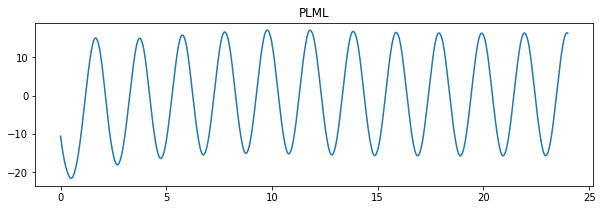

In [32]:
from util.neuron_metadata import *
from util.plot_util import *
import numpy as np
import pandas as pd
from neural_model import NeuralModel
neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json('data/chem.json')

model = NeuralModel(neuron_metadata_collection)
model.seed = 0
model.set_current_injection("AVBL", 2.3)
model.set_current_injection("AVBR", 2.3)
model.set_current_injection("PLML", 1.4)
model.set_current_injection("PLMR", 1.4)
model.init()
(v_mat, s_mat, v_normalized_mat) = model.run(2700)
# The oscillatory dynamic doesn't stabilize until about dt*300 onwards.
# Also, interactome analysis is done after the first 50 timesteps.
fwd_dynamics = v_normalized_mat[300:,:]

# Plot one neuron just to show the oscillation
plot_saved_dynamics(['PLML'], fwd_dynamics, neuron_metadata_collection)

In [4]:
# Get all the motor neurons
motor_neurons = []
for id in range(neuron_metadata_collection.get_size()):
    if neuron_metadata_collection.get_metadata(id).neuron_type == NeuronType.MOTOR:
        motor_neurons.append(id)
        
# Worm atlas says 113: "A total of 113 of the 302 C. elegans neurons belong to the motor neuron category"
# But, we get 109 motor neurons. Close enough.
# Let's extract out just the motor neurons' time series.
fwd_motor_dynamics = fwd_dynamics[:,motor_neurons]
fwd_motor_dynamics.shape

(2400, 109)

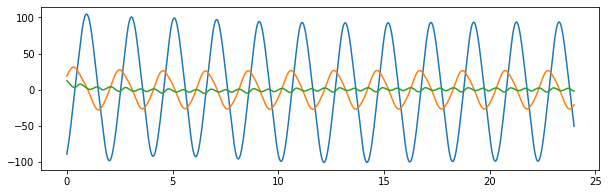

In [21]:
from sklearn.decomposition import PCA
# Perform mean-centering before PCA
X = fwd_motor_dynamics - fwd_motor_dynamics.mean(axis= 0)

pca = PCA(n_components=4)
projected_X = pca.fit_transform(X)
num_timesteps = fwd_motor_dynamics.shape[0]
times = np.arange(0, num_timesteps * 0.01 , 0.01)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(times, projected_X[:,0])
ax.plot(times, projected_X[:,1])
ax.plot(times, projected_X[:,2])
#ax.plot(times, projected_X[:,3])

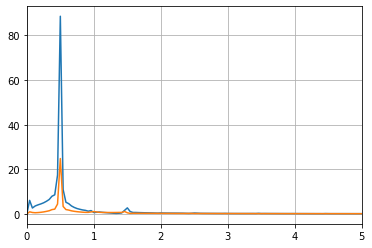

In [30]:
import numpy as np 
from scipy.fftpack import fft 
import matplotlib.pyplot as plt

N = len(projected_X[:,0]) 
t = 0.01

pc1_fft = fft(projected_X[:,0]) 
pc1_fft_freq = np.linspace(0., 1./(2. * t), N//2)

pc2_fft = fft(projected_X[:,1])
pc2_fft_freq = np.linspace(0., 1./(2. * t), N//2)

fig, ax1 = plt.subplots(nrows=1, ncols=1)


ax1.plot(pc1_fft_freq, 2.0/N * np.abs(pc1_fft[0:N//2])) 
ax1.plot(pc2_fft_freq, 2.0/N * np.abs(pc2_fft[0:N//2]))
ax1.set_xlim(0, 5)
plt.grid() 
plt.show()

Text(0.5, 0, 'Time (s)')

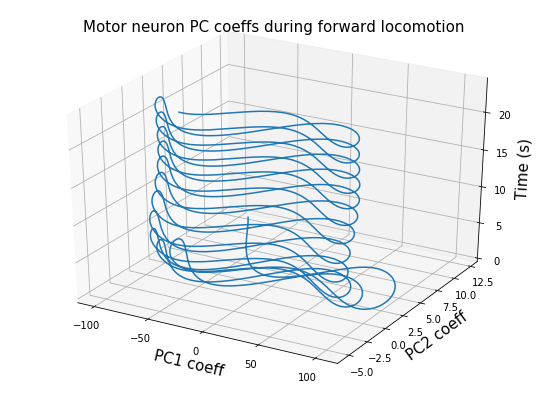

In [22]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(21,7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot(projected_X[:,0], projected_X[:,2], times)

ax.set_title("Motor neuron PC coeffs during forward locomotion", fontsize=15)
ax.set_xlabel('PC1 coeff', fontsize=15)
ax.set_ylabel('PC2 coeff', fontsize=15)
ax.set_zlabel('Time (s)', fontsize=15)